# Imports, Setup, Dataset

In [121]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime
import random
import matplotlib.gridspec as gridspec
import matplotlib
from collections import Counter

In [122]:
cap_path = '/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/cap_data_from_shardar.csv'
price_path = "/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/price_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
caps_df = pd.read_csv(cap_path, index_col='date')

# Drop troubled stock...
prices_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)
caps_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)

prices_df.head()
caps_df.head()

,ATW,A,AA,AAAB,AABC,AAC1,AACC,AACE,AACH,AADI,...,ZVIA,ZVOI,ZVRA,ZVUE,ZVXI,ZY,ZYME,ZYNE,ZYXI,ZZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.265785,14.803789,NaN,0.002968,0.000000,0.055383,NaN,0.074688,NaN,NaN,...,NaN,NaN,NaN,NaN,0.010821,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.355094,13.938379,NaN,0.001050,0.000000,0.093997,NaN,0.036322,NaN,NaN,...,NaN,NaN,NaN,NaN,0.001050,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.597657,15.593232,NaN,0.002262,0.000000,0.082724,NaN,0.042248,NaN,NaN,...,NaN,NaN,NaN,NaN,0.002725,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.377474,6.688876,NaN,0.003307,0.000000,0.071145,NaN,0.022496,NaN,NaN,...,NaN,NaN,NaN,NaN,0.006309,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.698268,8.061751,NaN,0.001843,0.000426,0.061952,NaN,0.005193,NaN,NaN,...,NaN,NaN,NaN,NaN,0.033459,NaN,NaN,NaN,NaN,NaN


In [123]:
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[-1]

# Download additional data:
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)

# Set up dataframes:
prices_with_market = prices_df.merge(spy_data, how='left', left_index=True, right_index=True)

[*********************100%%**********************]  1 of 1 completed


In [124]:
# Pulling rougly the first half of data
num_rows = len(prices_df)
print(f'Original Length: {num_rows}')
train_df = prices_df[:np.round(num_rows/2).astype(int)]
num_rows = len(train_df)
print(f'Train Length: {num_rows}')

Original Length: 5787
Train Length: 2894


In [125]:
# Let's identify stocks with no null values
complete_stock_list = train_df.columns
non_null_stocks = []
for stock in complete_stock_list:
    # get the count of nulls
    null_count = train_df[stock].isnull().sum()
    if null_count == 0:
        non_null_stocks.append(stock)

print(len(complete_stock_list))
print(len(non_null_stocks))

10806
2467


# Sectors

In [126]:
# non_null_stocks is the list of usable stocks
query = "EQR"

matches = [s for s in non_null_stocks if query in s]
print(matches)

['EQR']


In [127]:
Market_dict = {
    'Technology': ['AAPL','MSFT','NVDA','ORCL','CSCO','IBM','ADBE','AMD','TXN','INTC'],
    'Financial Services' : ['AXP','BLK','PGR','','','','','','',''],
    'Consumer Cyclical': ['AMZN','HD','MCD','BKNG','LOW','TJX','SBUX','ORLY','',''],
    'Healthcare' : ['LLY','UNH','JNJ','MRK','ABT','AMGN','CVS','','',''],
    'Communication Services': ['TTWO','OMC','EA','','','','','','',''],
    'Industrials' : ['CAT','UNP','HON','BA','DE','ETN','UPS','WM','MMM','CTAS'],
    'Consumer Defensive' : ['WMT','COST','PG','KO','PEP','MO','CL','TGT','MNST','KR'],
    'Energy': ['XOM','COP','CVX','EPD','EOG','WMB','SLB','OKE','VLO','EQT'],
    'Basic Materials' : ['SHW','APD','SCCO','ECL','NEM','VMC','MLM','NUE','PPG','STLD'],
    'Real Estate' : ['PLD','AVB','CSGP','IRM','EQR','','','','',''],
    'Utilities': ['','','','','','','','','','']
}
# This is just some of the stocks that are available... maybe this could be better solved later

# Functions

### Clustering

In [128]:
def get_corr_matrix(DataFrame):
    return DataFrame.corr()

In [129]:
def K_mean_cluster(DataFrame, num_clusters):
    X = get_corr_matrix(DataFrame)
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)
    cluster_dict = {}
    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = DataFrame.columns[i]
        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]
    return cluster_dict

In [130]:
def spectral_cluster(df, num_clusters):
    A = abs(df.corr().values)
    D = np.diag(A.sum(axis=1))
    L = D - A
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)
    cluster_dict = {}
    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]
        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]
    return cluster_dict

### Visualization

In [133]:
def cluster_viz(cluster_df, market_dict):
    timestamps = cluster_df.index.tolist()
    num_timestamps = len(timestamps)
    # Create a figure with 2 rows and 2 columns per timestamp (one per cluster)
    fig, axes = plt.subplots(nrows=2, ncols=num_timestamps * 2, figsize=(num_timestamps * 4, 6))
    # Loop over each timestamp and cluster
    for t, timestamp in enumerate(timestamps):
        row_data = cluster_df.loc[timestamp]  # Get the stock-cluster mapping for the timestamp
        # --- Add timestamp suptitle centered above its two columns ---
        fig.text(
            x=(t * 2 + 1) / (num_timestamps * 2),  # Centered above the two cluster columns
            y=1,  # Position above the plots
            s=str(timestamp),
            fontsize=14,
            fontweight="bold",
            ha="center"
        )
        for cluster in [0, 1]:
            # Find stocks that belong to this cluster
            stocks_in_cluster = row_data[row_data == cluster].index.tolist()
            # --- First row: Bar Plot of Stock Count by Sector ---
            sector_counts = {}
            for sector, sector_stocks in market_dict.items():
                valid_stocks = list(set(sector_stocks) & set(cluster_df.columns))
                count = sum([1 for stock in valid_stocks if stock in stocks_in_cluster])
                if count > 0:  # Only keep sectors that have at least one stock in the cluster
                    sector_counts[sector] = count
            ax_bar = axes[0, t * 2 + cluster]
            if sector_counts:
                sectors = list(sector_counts.keys())
                values = list(sector_counts.values())  
                ax_bar.bar(sectors, values)
                ax_bar.tick_params(axis='x', rotation=45)
            else:
                ax_bar.set_xticks([])
                ax_bar.set_yticks([])
                ax_bar.text(0.5, 0.5, "No sectors", ha="center", va="center", fontsize=10)
            ax_bar.set_title(f"Cluster {cluster}", fontsize=10)
            # --- Second row: Text Plot Listing Stocks by Sector ---
            text_str = ""
            for sector, sector_stocks in market_dict.items():
                valid_stocks = list(set(sector_stocks) & set(cluster_df.columns))
                stocks_in_sector = [stock for stock in valid_stocks if stock in stocks_in_cluster]    
                if stocks_in_sector:
                    stock_list = ", ".join(stocks_in_sector)
                    text_str += f"{sector}:\n{stock_list}\n\n"
            ax_text = axes[1, t * 2 + cluster]
            ax_text.axis('off')
            if text_str:
                ax_text.text(0.5, 0.5, text_str, ha="center", va="center", wrap=True, fontsize=8)
            else:
                ax_text.text(0.5, 0.5, "No sectors", ha="center", va="center", wrap=True, fontsize=10)  
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### Trading

In [170]:
def analyize_trade_history(trades_dict):
    pass

In [193]:
def monthly_trading(DataFrame,Sector_Dict, months_to_run, cluster_method, num_clusters):
    #### Setup
    output_data = []
    index = DataFrame.index.tolist() # Get the list of timestamps
    first_day = index[0] # Start from the first timestamp
    trades_dict = {} # {Stock_Name: {Open_date: [], Close_date: [], Open_direction: [], Open_price: [], Close_price: []}}
    currently_in_trade = []

    #### Monthly Iteration
    for _ in range(months_to_run):
        #### Setup
        new_row = {}
        last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0) 
        last_day_position = None
        current_last_day = last_day_of_month 
        new_row['timestamp'] = current_last_day
        while last_day_position is None: # Keep searching until we find a valid index position for the last day of the month
            try:
                last_day_position = next(
                    i for i, t in enumerate(index) if t.date() == current_last_day.date()
                )
            except StopIteration:
                current_last_day -= pd.Timedelta(days=1) # Backtrack by one day and try again if not found
                if current_last_day < first_day: # If backtracking goes too far, raise an error
                    raise ValueError(
                        f"Could not find a suitable last day for the month starting at {first_day}. "
                        "Backtracking exceeded the first day."
                    )
        next_day = current_last_day + pd.Timedelta(days=1) # Move to the next day after the last day of this month
        while next_day not in index: # Keep moving to the next day until a valid first day is found
            next_day += pd.Timedelta(days=1)

        #### Trading PT 1
        # check for stock/s in trade
            #check if there are any first
            if len(currently_in_trade) > 0:
                # iterate over the list
                for stock in currently_in_trade: 
                    # access the dictionary and close the stock
                    open_day = trades_dict[stock]['Open_date'][-1]
                    open_price = trades_dict[stock]['Open_price'][-1]
                    close_price = DataFrame.loc[current_last_day, stock]
                    trades_dict[stock]['Close_date'].append(current_last_day)
                    trades_dict[stock]['Close_price'].append(close_price)
                    if trades_dict[stock]['Trade_type'][-1] == 'Short':
                        profit = (open_price-close_price)/open_price
                    else: # 'Long'
                        profit = (close_price-open_price)/open_price
                    trades_dict[stock]['Profit'].append(profit)
                    currently_in_trade.remove(stock)

        #### Clustering
        if cluster_method == 'KMeans': # determine clustering method
            cluster_entry = K_mean_cluster(DataFrame[first_day:last_day_of_month], num_clusters)
        else:
            cluster_entry = spectral_cluster(DataFrame[first_day:last_day_of_month], num_clusters)
        for cluster in list(cluster_entry.keys()): # assign the the cluster members appropriately
            new_row[f'Cluster_{cluster}_Members'] = cluster_entry[cluster]

            #### Metrics calculation
            calcs = []
            clusters_stocks = cluster_entry[cluster]
            stock_to_sector = {stock: sector for sector, stocks in Sector_Dict.items() for stock in stocks}
            sector_count = Counter(stock_to_sector[stock] for stock in clusters_stocks if stock in stock_to_sector)
            majority_sector, majority_count = sector_count.most_common(1)[0]
            total_stocks = len(clusters_stocks)
            purity = (majority_count / total_stocks)
            calcs.append((f'Cluster_{cluster}_Purity',purity))   
            missclassification_rate = (1-(purity))
            calcs.append((f'Cluster_{cluster}_MR',missclassification_rate))
            if purity == 0 or purity == 1:
                entropy = 0  # log2(0) is undefined, and entropy should be 0 for pure sets
            else:
                entropy = -1 * ((purity * np.log2(purity)) + ((1 - purity) * np.log2(1 - purity)))
            calcs.append((f'Cluster_{cluster}_Entropy',entropy))
            for i in calcs: # assign the values appropriately
                key = i[0]
                val = i[1]
                new_row[key] = val
            missclassified_stocks = []
            correctly_classified_stocks = []
            if (purity > 0.5) and (purity != 1):
                missclassified_stocks = [stock for stock in clusters_stocks # record the missclassified stocks
                            if stock_to_sector.get(stock) != majority_sector] 
                correctly_classified_stocks = [stock for stock in clusters_stocks # record the correctly classified stocks
                            if stock_to_sector.get(stock) == majority_sector]
            new_row[f'Cluster_{cluster}_MisclassifiedStocks'] = missclassified_stocks

            ### Trading PT 2
            # open up new trades if possible
            if len(missclassified_stocks) == 1:
                # find the sector:
                trading_stock = missclassified_stocks[0] 
                for sector, stocks in Sector_Dict.items():
                    if trading_stock in stocks:
                        target_sector = sector
                # find its peers
                peer_stocks = []
                for stk in Sector_Dict[target_sector]:
                    if stk in DataFrame.columns:
                        peer_stocks.append(stk)
                peer_stocks.remove(trading_stock)
                # Check its peers' behavior
                up_cntr = 0
                down_cntr = 0
                for stk in peer_stocks:
                    price_data = DataFrame[stk][first_day:current_last_day]
                    covariance = np.cov(range(len(price_data)), price_data.values)
                    beta = covariance[0,1]
                    if beta > 0:
                        up_cntr +=1
                    else:
                        down_cntr +=1
                if up_cntr > down_cntr:
                    Trade_type = 'Long'
                else:
                    Trade_type = 'Short'
                # open the trade & record it
                # check if the stock exists in trades_dict, otherwise we have to create it
                current_price = DataFrame.loc[current_last_day, trading_stock]
                if trading_stock in list(trades_dict.keys()):
                    trades_dict[trading_stock]['Open_date'].append(current_last_day)
                    trades_dict[trading_stock]['Trade_type'].append(Trade_type)
                    trades_dict[trading_stock]['Open_price'].append(current_price)
                else: 
                    trades_dict[trading_stock] = {
                        'Open_date':[current_last_day],
                        'Close_date':[],
                        'Trade_type':[Trade_type],
                        'Open_price':[current_price],
                        'Close_price':[],
                        'Profit':[],
                    }
                currently_in_trade.append(trading_stock)

        #### Cleanup
        first_day = next_day # Set the first day for the next month
        output_data.append(new_row) # Append the month's row

    #### Output
    df = pd.DataFrame(output_data)
    df.set_index('timestamp', inplace=True)
    return df, trades_dict


In [200]:
def calc_avg_profit(trading_dict):
    all_profits = []
    for stock in list(trading_dict.keys()):
        profits = trading_dict[stock]['Profit']
        for profit in profits:
            all_profits.append(profit)
    return (sum(all_profits)/len(all_profits))

# Testing

In [194]:
stocks_to_run = ['AAPL', 'MSFT', 'NVDA', 'ORCL','XOM', 'COP', 'CVX', 'EPD']
results_df, trading_results = monthly_trading(train_df[stocks_to_run],Market_dict, 15, "KMeans", 2)
results_df

,Cluster_1_Members,Cluster_1_Purity,Cluster_1_MR,Cluster_1_Entropy,Cluster_1_MisclassifiedStocks,Cluster_0_Members,Cluster_0_Purity,Cluster_0_MR,Cluster_0_Entropy,Cluster_0_MisclassifiedStocks
timestamp,,,,,,,,,,
2000-01-31,"[AAPL, EPD]",0.500000,0.500000,1.000000,[],"[MSFT, NVDA, ORCL, XOM, COP, CVX]",0.500000,0.500000,1.000000,[]
2000-02-29,"[MSFT, XOM, COP, CVX, EPD]",0.800000,0.200000,0.721928,[MSFT],"[AAPL, NVDA, ORCL]",1.000000,0.000000,0.000000,[]
2000-03-31,"[NVDA, XOM, EPD]",0.666667,0.333333,0.918296,[NVDA],"[AAPL, MSFT, ORCL, COP, CVX]",0.600000,0.400000,0.970951,"[COP, CVX]"
2000-04-30,"[COP, EPD]",1.000000,0.000000,0.000000,[],"[AAPL, MSFT, NVDA, ORCL, XOM, CVX]",0.666667,0.333333,0.918296,"[XOM, CVX]"
2000-05-31,"[NVDA, XOM, COP, CVX, EPD]",0.800000,0.200000,0.721928,[NVDA],"[AAPL, MSFT, ORCL]",1.000000,0.000000,0.000000,[]
2000-06-30,"[COP, CVX]",1.000000,0.000000,0.000000,[],"[AAPL, MSFT, NVDA, ORCL, XOM, EPD]",0.666667,0.333333,0.918296,"[XOM, EPD]"
2000-07-31,"[AAPL, MSFT, NVDA, XOM, COP, CVX]",0.500000,0.500000,1.000000,[],"[ORCL, EPD]",0.500000,0.500000,1.000000,[]
2000-08-31,[MSFT],1.000000,0.000000,0.000000,[],"[AAPL, NVDA, ORCL, XOM, COP, CVX, EPD]",0.571429,0.428571,0.985228,"[AAPL, NVDA, ORCL]"
2000-09-30,"[AAPL, MSFT, ORCL, COP, CVX]",0.600000,0.400000,0.970951,"[COP, CVX]","[NVDA, XOM, EPD]",0.666667,0.333333,0.918296,[NVDA]


In [195]:
trading_results

{'MSFT': {'Open_date': [Timestamp('2000-02-29 00:00:00')],
  'Close_date': [Timestamp('2000-03-31 00:00:00')],
  'Trade_type': ['Long'],
  'Open_price': [27.76],
  'Close_price': [33.003],
  'Profit': [0.18886887608069158]},
 'NVDA': {'Open_date': [Timestamp('2000-03-31 00:00:00'),
   Timestamp('2000-05-31 00:00:00'),
   Timestamp('2000-09-29 00:00:00'),
   Timestamp('2001-02-28 00:00:00')],
  'Close_date': [Timestamp('2000-04-28 00:00:00'),
   Timestamp('2000-06-30 00:00:00'),
   Timestamp('2000-12-29 00:00:00')],
  'Trade_type': ['Long', 'Short', 'Short', 'Short'],
  'Open_price': [1.615, 2.156, 3.13, 1.708],
  'Close_price': [1.704, 2.43, 1.253],
  'Profit': [0.055108359133126915, -0.12708719851576994, 0.5996805111821086]},
 'XOM': {'Open_date': [Timestamp('2000-12-29 00:00:00'),
   Timestamp('2001-02-28 00:00:00')],
  'Close_date': [Timestamp('2001-03-30 00:00:00'),
   Timestamp('2001-03-30 00:00:00')],
  'Trade_type': ['Long', 'Long'],
  'Open_price': [20.949, 19.632],
  'Close_pr

In [201]:
calc_avg_profit(trading_results)

0.17139412810024238

<Axes: xlabel='timestamp'>

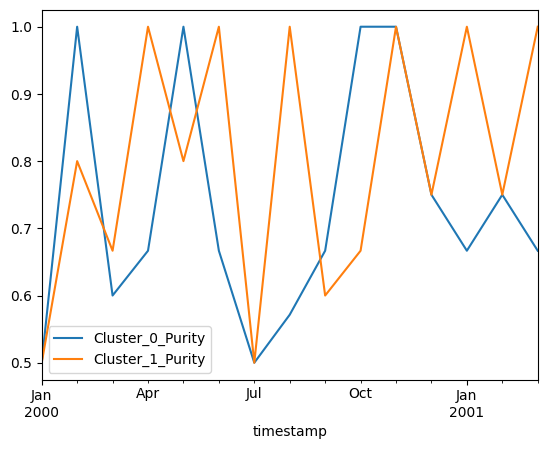

In [202]:
results_df[['Cluster_0_Purity', 'Cluster_1_Purity']].plot()